In [1]:
%load_ext autoreload
%autoreload 2


import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from pvi.models.sgp import SparseGaussianProcessModel

import torch
import numpy as np
import matplotlib.pyplot as plt
import gpytorch

from torch import nn
from gpytorch.kernels import ScaleKernel, RBFKernel

%matplotlib inline
torch.set_default_dtype(torch.float64)

# Set up data and helper functions

In [3]:
x = np.linspace(-1, 1, 50)
y = 2 * np.sin(5*x) + 3 * np.abs(x) * np.random.rand(len(x))

x = torch.tensor(x).unsqueeze(1)
y = torch.tensor(y).unsqueeze(1)

In [4]:
def plot_data(x, y):
    plt.figure()
    plt.grid(b=True)
    plt.scatter(x, y)
    plt.show()
    
def plot_results(x, y, model):
    pp = model(x)
    mean = pp.mean.detach()
    std = pp.variance.detach() ** 0.5
    
    samples = pp.sample((20,))
    
    plt.figure()
    plt.grid(b=True)
    
    for sample in samples:
        plt.plot(x, sample, color='k', alpha=.1)
        
    plt.plot(x.squeeze(-1), mean)
    plt.fill_between(x.squeeze(-1), mean-1.96*std, mean+1.96*std, alpha=.25)
    plt.scatter(x, y)
    plt.show()
    
def plot_training(training_array):
    x_vals = np.arange(1, len(training_array)+1)
    plt.figure()
    plt.grid(b=True)
    plt.plot(x_vals, training_array)
    plt.ylabel('ELBO Loss')
    plt.xlabel('Step')
    plt.show()
    
data = {
    "x": x,
    "y": y,
}

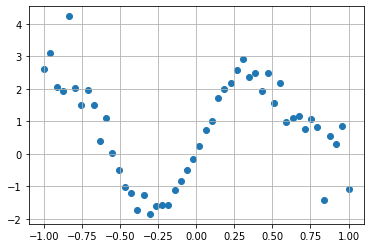

In [5]:
plot_data(x, y)

# Construct SGP model

In [6]:
hyperparameters = {
    "D": 1,
    "num_inducing": 5,
    "kernel_class": RBFKernel,
    "kernel_params": {"lengthscale": .5},
    "epochs": 500,
    "optimiser_params": {"lr": 1e-3}
}

inducing_locations = x[::10]

model = SparseGaussianProcessModel(inducing_locations=inducing_locations.clone(), 
                                   output_sigma=1., hyperparameters=hyperparameters)

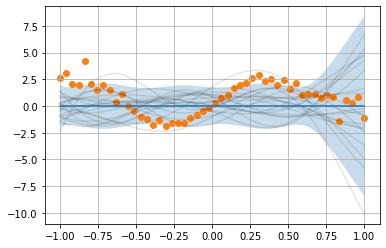

In [7]:
plot_results(x, y, model)

# Fit data

In [8]:
t = {
    "np1": torch.tensor([0.]*model.hyperparameters["num_inducing"]),
    "np2": torch.tensor([0.]*model.hyperparameters["num_inducing"]).diag_embed()
}

In [9]:
t_new = model.fit(data, t)

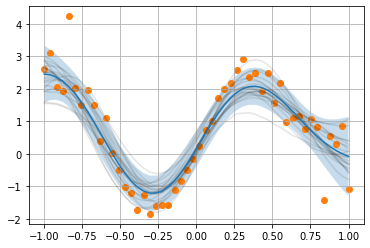

In [10]:
plot_results(x, y, model)